# 🎧 Annoy (Approximate Nearest Neighbors Oh Yeah) Classification

In this notebook, we explore Annoy classification with:

- **Synthetic data** generated with Gaussian noise
- Implementing a **weighted k-NN with Gaussian kernel**
  
Evaluation metrics and visualizations are included for comparison.

In [1]:
import heapq

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.random import Generator
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

## 🛠️ Utils

In [2]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [3]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


def plot_clusters(
    data: NDArray[np.float64],
    centers: NDArray[np.float64],
    X_test: NDArray[np.float64],
    predicted: NDArray[np.int64],
    labels: NDArray[np.int64],
    subtitle: str = "Clustering Overview",
) -> None:
    """Plot original clusters and predictions on test data.

    Args:
        data (NDArray[np.float64]): Original dataset (n_samples, 2).
        centers (NDArray[np.float64]): Cluster centers (n_clusters, 2).
        X_test (NDArray[np.float64]): Test data points (n_test_samples, 2).
        predicted (NDArray[np.int64]): Predicted cluster labels or outputs.
        labels (NDArray[np.int64]): Ground truth labels for training data.
        subtitle (str): Title for the entire plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(subtitle)

    # Plot original data and cluster centers
    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=labels,
        alpha=0.5,
        palette="Set2",
        ax=axes[0],
    )
    axes[0].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=100,
        marker="x",
        label="Centers",
    )
    axes[0].set_title("Original Data and Cluster Centers")
    axes[0].legend()

    # Plot predictions
    axes[1].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=predicted,
        cmap="tab10",
        alpha=0.5,
    )
    axes[1].set_title("Predictions on Test Data")

    plt.tight_layout()
    plt.show()

## 📊 Generate Dataset

In [4]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=1000, num_clusters=4, space_size=50, noise_level=7, dim=2, seed=412
)

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## ⚖️ Weighted k-nearest neighbors with Annoy

In [6]:
class AnnoyNode:
    """Node used in the Annoy tree.

    Attributes:
        points (NDArray[np.float64]): Data points stored in the node.
        labels (NDArray[np.float64]): Corresponding labels for the data points.
        split_point (NDArray[np.float64] | None): Reference point for the
            hyperplane split.
        normal (NDArray[np.float64] | None): Normal vector defining the
            split hyperplane.
        left (AnnoyNode | None): Left subtree (positive side of the hyperplane).
        right (AnnoyNode | None): Right subtree (negative side of the hyperplane).
        leaf (bool): Whether this node is a leaf (i.e., contains <= leaf_size points).
    """

    def __init__(
        self, points: NDArray[np.float64], labels: NDArray[np.float64]
    ) -> None:
        """Initialize an AnnoyNode with given data points and their labels.

        Args:
            points (NDArray[np.float64]): Data points stored in this node.
            labels (NDArray[np.float64]): Labels corresponding to the data points.
        """
        self.leaf: bool = False
        self.points: NDArray[np.float64] = points
        self.labels: NDArray[np.float64] = labels
        self.split_point: NDArray[np.float64] | None = None
        self.normal: NDArray[np.float64] | None = None
        self.left: "AnnoyNode" | None = None
        self.right: "AnnoyNode" | None = None


class Annoy:
    """Approximate Nearest Neighbors (ANN) structure using random projection trees.

    Attributes:
        k (int): Dimensionality of the feature space.
        root (AnnoyNode): Root node of the built tree.
        leaf_size (int): Maximum number of points in a leaf node.
        p (float): Order of the Minkowski distance used for nearest neighbor search.
        rng (Generator): Random number generator used for hyperplane sampling.
    """

    def __init__(
        self,
        points: NDArray[np.float64],
        labels: NDArray[np.float64],
        leaf_size: int = 5,
        p: float = 2.0,
        seed: int = 42,
    ) -> None:
        """Construct the Annoy tree from the provided points and labels.

        Args:
            points (NDArray[np.float64]): Array of data points,
                shape (n_samples, n_features).
            labels (NDArray[np.float64]): Corresponding labels for the points.
            leaf_size (int, optional): Maximum number of points per leaf. Defaults to 5.
            p (float, optional): Minkowski distance order. Defaults to 2 (Euclidean).
            seed (int, optional): Random seed for reproducibility. Defaults to 42.
        """
        self.k: int = points.shape[1] if points.size else 0
        self.leaf_size: int = leaf_size
        self.p: float = p
        self.rng: Generator = np.random.default_rng(seed)
        self.root: AnnoyNode = self.build(points, labels)

    def _minkowski_metric(
        self, a: NDArray[np.float64], b: NDArray[np.float64], p: float = 2.0
    ) -> float:
        """Calculate Minkowski distance of order p between two points.

        Args:
            a (NDArray[np.float64]): First point.
            b (NDArray[np.float64]): Second point.
            p (float): Order of the Minkowski distance.

        Returns:
            float: Minkowski distance between points a and b.
        """
        return np.sum(np.abs(a - b) ** p) ** (1 / p)

    def build(
        self, points: NDArray[np.float64], labels: NDArray[np.float64]
    ) -> AnnoyNode | None:
        """Recursively build the Annoy tree from the given points and labels.

        Args:
            points (NDArray[np.float64]): Data points to build the tree with.
            labels (NDArray[np.float64]): Corresponding labels.

        Returns:
            AnnoyNode | None: The root of the constructed subtree, or None if empty.
        """
        if points.shape[0] == 0:
            return None

        node = AnnoyNode(points, labels)

        if points.shape[0] <= self.leaf_size:
            node.leaf = True
            return node

        i1, i2 = self.rng.choice(points.shape[0], size=2, replace=False)
        p1, p2 = points[i1], points[i2]
        node.normal = p2 - p1
        node.split_point = p1

        proj = np.dot(points - p1, node.normal)

        node.left = self.build(points[proj > 0], labels[proj > 0])
        node.right = self.build(points[proj <= 0], labels[proj <= 0])

        return node

    def _search_k_nearest_neighbors(
        self,
        point: NDArray[np.float64],
        k: int,
        node: AnnoyNode,
        best_heap: list[tuple[float, float]],
    ) -> list[tuple[float, AnnoyNode]]:
        """Recursively search for k nearest neighbors of a query point.

        Args:
            point (NDArray[np.float64]): Query point.
            k (int): Number of nearest neighbors to retrieve.
            node (AnnoyNode): Current node in the tree.
            best_heap (list[tuple[float, float]]): Max-heap storing (-distance, label)
                for the current best neighbors.

        Returns:
            list[tuple[float, float]]: Heap of k nearest neighbors as
                (-distance, label).
        """
        if node is None:
            return best_heap

        if node.leaf:
            for node_point, node_label in zip(node.points, node.labels, strict=False):
                dist = self._minkowski_metric(point, node_point, self.p)

                if len(best_heap) < k:
                    heapq.heappush(best_heap, (-dist, node_label))
                    continue

                if dist < -best_heap[0][0]:
                    heapq.heappushpop(best_heap, (-dist, node_label))

            return best_heap

        side: float = 0.0
        if node.normal is not None and node.split_point is not None:
            side = np.dot(point - node.split_point, node.normal)

        if side > 0:
            next_branch, other_branch = node.left, node.right
        else:
            next_branch, other_branch = node.right, node.left

        self._search_k_nearest_neighbors(point, k, next_branch, best_heap)

        if len(best_heap) < k or abs(side) < -best_heap[0][0]:
            self._search_k_nearest_neighbors(point, k, other_branch, best_heap)

        return best_heap

    def search_k_nearest_neighbors(
        self,
        point: NDArray[np.float64],
        k: int,
    ) -> list[tuple[float, AnnoyNode]]:
        """Find the k nearest neighbors of the query point using the Annoy tree.

        Args:
            point (NDArray[np.float64]): Query point to search for.
            k (int): Number of neighbors to return.

        Returns:
            tuple[NDArray[np.float64], NDArray[np.float64]]:
                Distances and labels of the k nearest neighbors, both as arrays.
        """
        best_heap = self._search_k_nearest_neighbors(point, k, self.root, [])
        neighbors = sorted(best_heap, key=lambda x: -x[0])

        neighbor_distances, neighbor_labels = zip(*neighbors, strict=False)
        neighbor_distances = -np.array(neighbor_distances)
        neighbor_labels = np.array(neighbor_labels)

        return neighbor_distances, neighbor_labels

In [7]:
def gaussian_kernel(t: NDArray[np.float64] | float) -> NDArray[np.float64] | float:
    """Gaussian (normal) kernel function.

    Args:
        t (NDArray[np.float64] | float): Input value(s).

    Returns:
        NDArray[np.float64] | float: Kernel-weighted value(s).
    """
    return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)


def weighted_knn_kernel(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    X_test: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
    h: float = 1.0,
) -> NDArray[np.float64]:
    """Predict labels using weighted k-NN with a Gaussian kernel and Annoy.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        X_test (NDArray[np.float64]): Test features, shape (n_test_samples, n_features).
        k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
        p (float, optional): Order of the Minkowski distance. Defaults to 2.0.
        h (float, optional): Bandwidth parameter for the Gaussian kernel. Defaults to 1.

    Returns:
        NDArray[np.float64]: Predicted labels for each sample in X_test.
    """
    annoy = Annoy(X_train, y_train, p=p, leaf_size=20)

    y_predicted: list[float] = []

    for x_new in X_test:
        neighbor_distances, neighbor_labels = annoy.search_k_nearest_neighbors(
            x_new, k_neighbors
        )

        weights = gaussian_kernel(neighbor_distances / h)

        class_weights = {}
        for label, weight in zip(neighbor_labels, weights, strict=False):
            class_weights[label] = class_weights.get(label, 0) + weight

        predicted_label = max(class_weights, key=class_weights.get)
        y_predicted.append(predicted_label)

    return np.array(y_predicted)


# Predict labels for all samples in X_test
predicted = weighted_knn_kernel(X_train, y_train, X_test, k_neighbors=5, p=5, h=5.8)

Accuracy:  0.9250
Precision: 0.9254
Recall:    0.9250
F1 Score:  0.9250


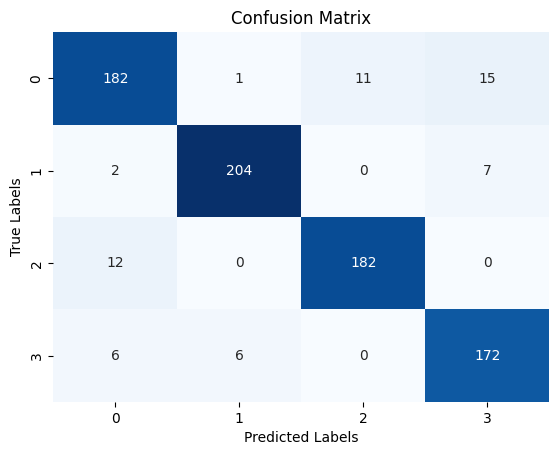

In [8]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

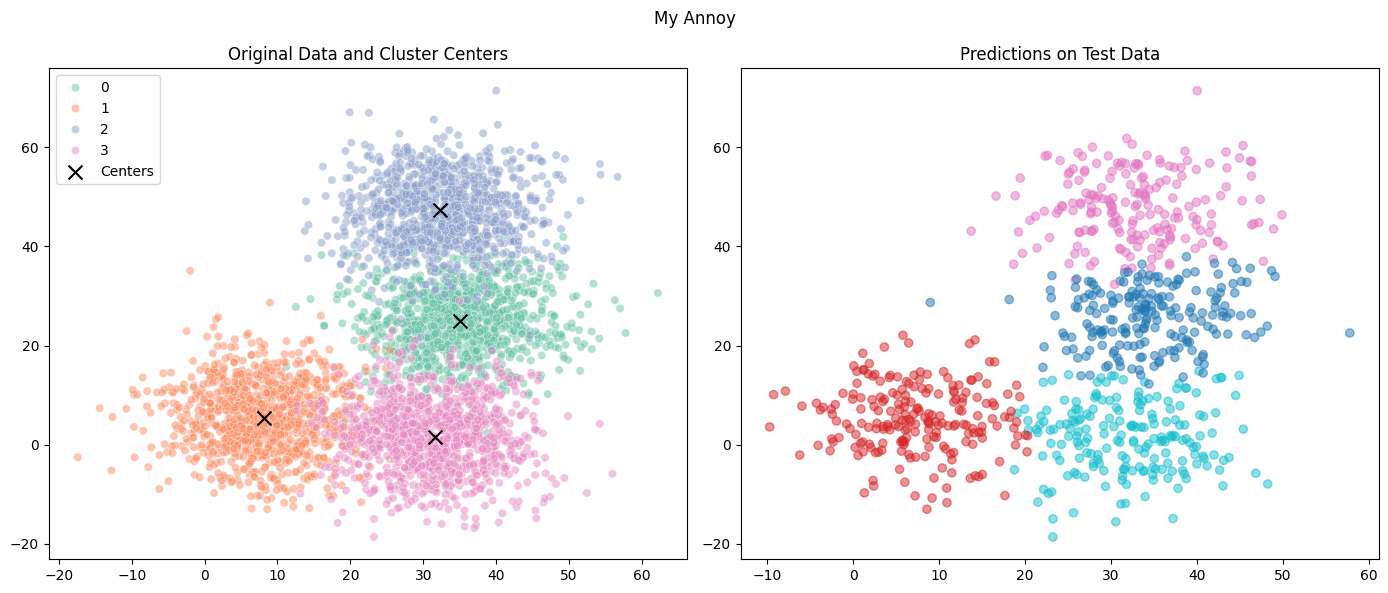

In [9]:
plot_clusters(data, centers, X_test, predicted, labels, "My Annoy")